In [1]:
# Magic commands
%matplotlib inline

# External packages
import os
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from qutip import *
from pylab import *
from ipywidgets import widgets
from IPython.display import display, HTML

# cQED modules
from plotsettings import *
from plots import *
from supports import *
from process import *
from calculate import *
from envelopes import *
from scan import *

home = os.getcwd() + "/"

In [21]:
# Device 
Nq = 10         # number of levels in qubit
Nc = 10         # number of levels in resonator 1
wq = 6.5 *2*pi  # g-e qubit transition frequency
wc = 4.0 *2*pi  # bare resonator frequency
Ec = 0.2 *2*pi  # anharmonicity (charging energy)
g  = 0.2 *2*pi  # coupling between qubit and resonator

# Sideband transitions
Nt = 1      # number of drive tones

# Single-tone
eps = 0.4 *2 *2*pi  # pump drive amplitude
wd  = 1.25 *2*pi  # monochromatic drive frequency

# Double-tone
epsfac = 1.0                     # factor with which to scale the drive tone amplitudes
epsq   = epsfac * 0.025 *2 *2*pi  # amplitude of qubit-friendly drive tone
epsc   = epsfac * 0.317 *2 *2*pi  # amplitude of cavity-friendly drive tone
dw     = 0.5 *2*pi               # detuning of wdc from wc
wdq    = 4.4799 *2*pi            # frequency of qubit-friendly drive tone
wdc    = wc - dw                 # frequency of cavity-friendly drive tone

tlist = np.linspace(0, 2*pi/wd, 100)

In [22]:
b, a, nq, nc = ops(Nq, Nc)  # Operators

# Individual Hamiltonian terms
Hi_Kerr = wq*nq      + wc*nc - Ec/2*b.dag()*b.dag()*b*b  # devices intrinsic
Hi_Duff = (wq+Ec)*nq + wc*nc - Ec/12*(b + b.dag())**4
Hc = g*(a + a.dag())*(b + b.dag())  # coupling

In [23]:
g0 = [list(), list()]
g1 = [list(), list()]
e0 = [list(), list()]
e1 = [list(), list()]
f0 = [list(), list()]

for t in tlist:
    if Nt == 1:
        Hd = eps*cos(wd*t)*(b + b.dag())    # single-tone drive
        H_Kerr = Hi_Kerr + Hc + Hd
        H_Duff = Hi_Duff + Hc + Hd
    elif Nt == 2:
        Hdq = epsq*cos(wdq*t)*(b + b.dag())  # double-tone qubit-friendly drive
        Hdc = epsc*cos(wdc*t)*(b + b.dag())  # double-tone cavity-friendly drive
        H_Kerr = Hi_Kerr + Hc + Hdq + Hdc
        H_Duff = Hi_Duff + Hc + Hdq + Hdc
    
    for i, H in enumerate((H_Kerr, H_Duff)):
        EE = H.eigenenergies()
        g0[i].append(EE[0])
        if wq > wc:
            g1[i].append(EE[1])
            e0[i].append(EE[2])
            f0[i].append(EE[6])
        elif wq < wc:
            g1[i].append(EE[2])
            e0[i].append(EE[1])
        e1[i].append(EE[4])

g0 = np.asarray(g0)
g1 = np.asarray(g1)
e0 = np.asarray(e0)
e1 = np.asarray(e1)
f0 = np.asarray(f0)
e0g1 = e0-g1
e1g0 = e1-g0
e0g0 = e0-g0
e1g1 = e1-g1
e0f0 = f0-e0

In [24]:
Delta = wd-wq
Sigma = wd+wq
mod_Kerr = -eps**2*Ec/2*(1/Delta**2 + 1/Sigma**2 - 2/(Delta*Sigma)*np.cos(2*wd*tlist))
mod_Duff = -eps**2*Ec/2*(1/Delta**2 + 1/Sigma**2 - 2/(Delta*Sigma))*(1 + np.cos(2*wd*tlist))

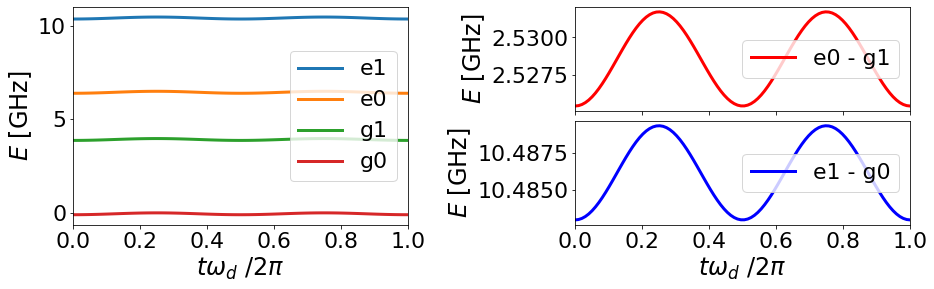

In [25]:
plt.subplots(1, 3, figsize=[15, 4])

plt.subplot(1, 2, 1)
plt.plot(tlist*wd/2/pi, e1[0]/2/pi, label="e1")
plt.plot(tlist*wd/2/pi, e0[0]/2/pi, label="e0")
plt.plot(tlist*wd/2/pi, g1[0]/2/pi, label="g1")
plt.plot(tlist*wd/2/pi, g0[0]/2/pi, label="g0")

plt.xlim([0,1])
plt.xlabel("$t \\omega_d$ $/2\\pi$")
plt.ylabel("$E$ [GHz]")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(tlist*wd/2/pi, e0g1[0]/2/pi, c='r', label="e0 - g1")
plt.xlim([0,1])
plt.gca().set_xticklabels([])
plt.ylabel("$E$ [GHz]")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(tlist*wd/2/pi, e1g0[0]/2/pi, c='b', label="e1 - g0")
plt.xlim([0,1])
y_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.gca().yaxis.set_major_formatter(y_formatter)
plt.xlabel("$t \\omega_d$ $/2\\pi$")
plt.ylabel("$E$ [GHz]")
plt.legend()

plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.1)
plt.show()

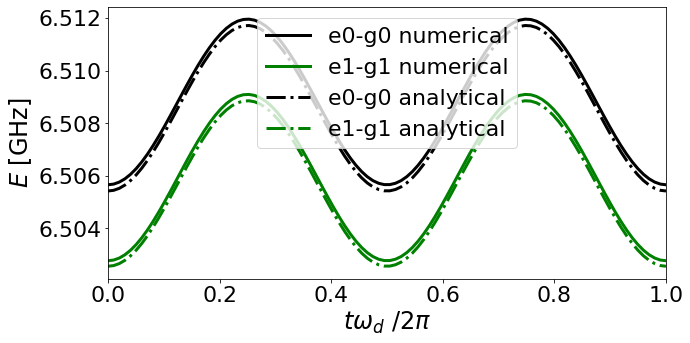

In [26]:
EE = (Hi_Kerr+Hc).eigenenergies()

plt.figure(figsize=figsize)
plt.plot(tlist*wd/2/pi, e0g0[0]/2/pi, c='k', label="e0-g0 numerical")
plt.plot(tlist*wd/2/pi, e1g1[0]/2/pi, c='g', label="e1-g1 numerical")
plt.plot(tlist*wd/2/pi, (EE[2]-EE[0])/2/pi + mod_Kerr/2/pi, '-.', c='k', label='e0-g0 analytical')
plt.plot(tlist*wd/2/pi, (EE[4]-EE[1])/2/pi + mod_Kerr/2/pi, '-.', c='g', label='e1-g1 analytical')

plt.xlim([0,1])
plt.xlabel("$t \\omega_d$ $/2\\pi$")
plt.ylabel("$E$ [GHz]")
plt.legend()
plt.show()

In [14]:
EE = (Hi+Hc).eigenenergies()

# plt.plot(tlist*wd/2/pi, e0g1/2/pi, c='k', label="e0-g1 numerical")
plt.plot(tlist*wd/2/pi, e0g0/2/pi, c='g', label="e1-g0 numerical")


plt.xlim([0,1])
plt.xlabel("$t \\omega_d$ $/2\\pi$")
plt.ylabel("$E$ [GHz]")
plt.legend()
plt.show()

NameError: name 'Hi' is not defined

In [ ]:
EE = (Hi+Hc).eigenenergies()

# plt.plot(tlist*wd/2/pi, e0g1/2/pi, c='k', label="e0-g1 numerical")
plt.plot(tlist*wd/2/pi, (e0f0)/2/pi, c='g', label="e0-f0 numerical")


plt.xlim([0,1])
plt.xlabel("$t \\omega_d$ $/2\\pi$")
plt.ylabel("$E$ [GHz]")
plt.legend()
plt.show()